# Evaluation of SSL methods

In this session we are going to implement the following evaluation modalities of SSL methods:
- kNN classifier
- linear probe
- MLP

We are going to use the ImageNet pretrained model of pytorch as pretrained model and test their performance of CIFAR10 (as we have already done in the CNN lab classes before in the course).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

import torch.nn as nn
import torch.optim as optim

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# TODO prova a cercare vero modello pretrained self supervised (su torchvision) e cercare di adattarlo su ImageNet
# Tabella con mia rete, from scratch, fine tuning supervised, e poi self supervised KNN, linear probing, mlp e finetuning

## Exercise 0

Create a linear probe on CIFAR10 using the pretrained model of torchvision, models.resnet18(pretrained=True).

Keep attention to set the model in evaluation mode with model.eval() during the training of the linear layer, since all the layers of the pretrained model should be used in eval mode (eg the batch norm/dropout layers, if present).

In [4]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)

for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

batch_size = 64
epochs = 10

criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-04)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.to(device)
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())
    return np.mean(losses)

def test(model, device, test_loader, val=False):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion_test(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    mode = "Val" if val else "Test"
    print('\{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        mode,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [6]:
# the main loop
train_losses = []

model.eval()
for epoch in range(1, epochs + 1):
    train_loss = train(model, 'cuda', trainloader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, 'cuda', testloader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.632349
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.105431
\Test set: Average loss: 2.0875, Accuracy: 2661/10000 (27%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.118914
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.882587
\Test set: Average loss: 1.9360, Accuracy: 3214/10000 (32%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.896930
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.989497
\Test set: Average loss: 1.8777, Accuracy: 3423/10000 (34%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.771980
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.857123
\Test set: Average loss: 1.8208, Accuracy: 3644/10000 (36%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.806460
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.796793
\Test set: Average loss: 1.7929, Accuracy: 3746/10000 (37%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.719769
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.717611
\Test set: Average loss: 1.7755, Accuracy: 3846/10000 (38%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.829522
Train Epoch: 7 [320

## Exercise 1

Compare the linear evaluation with the MLP strategy.

Implement now a MLP on top of the model and train just this part.
Also in this case keep attention to set the model in evaluation mode with model.eval() during the training of the linear layer, since all the layers of the pretrained model should be used in eval mode (eg the batch norm/dropout layers, if present).

In [7]:
modelMLP = models.resnet18(pretrained = True)
modelMLP.fc = nn.Sequential(
        nn.Linear(512, 128),
        #nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 10)
    )

for param in modelMLP.parameters():
    param.requires_grad = False
for param in modelMLP.fc.parameters():
    param.requires_grad = True

batch_size = 64
epochs = 10

criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(modelMLP.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-04)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
train_losses = []

modelMLP.eval()
for epoch in range(1, epochs + 1):
    train_loss = train(modelMLP, 'cuda', trainloader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(modelMLP, 'cuda', testloader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.322727
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.282910
\Test set: Average loss: 2.2196, Accuracy: 1754/10000 (18%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.222858
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.159822
\Test set: Average loss: 2.1092, Accuracy: 2393/10000 (24%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.123163
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.024951
\Test set: Average loss: 2.0163, Accuracy: 2728/10000 (27%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.079273
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.926161
\Test set: Average loss: 1.9377, Accuracy: 3055/10000 (31%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.943005
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.887912
\Test set: Average loss: 1.8980, Accuracy: 3249/10000 (32%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.855822
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.975746
\Test set: Average loss: 1.8553, Accuracy: 3354/10000 (34%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.758836
Train Epoch: 7 [320

## Exercise 2

Implement the KNN classifier. Test several values of k.

In [9]:
# con  il training costruisco i centroidi
device = 'cuda'
modelKNN = models.resnet18(pretrained = True)
modelKNN.fc = nn.Identity()
modelKNN.to(device)
modelKNN.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
training_features = None
training_labels = None
with torch.no_grad():
   for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if training_labels is None:
        training_labels = torch.zeros(len(trainloader.dataset))
      training_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = modelKNN(inputs)
      if training_features is None:
        training_features = torch.zeros(len(trainloader.dataset), features.shape[-1])
      training_features[i*batch_size: (i+1)*batch_size]=features

In [12]:
testing_features = None
testing_labels = None
with torch.no_grad():
   for i, data in enumerate(testloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if testing_labels is None:
        testing_labels = torch.zeros(len(testloader.dataset))
      testing_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = modelKNN(inputs)
      if testing_features is None:
        testing_features = torch.zeros(len(testloader.dataset), features.shape[-1])
      testing_features[i*batch_size: (i+1)*batch_size]=features

In [13]:
from sklearn.cluster import MiniBatchKMeans

def knn_classifier(train_features, train_labels, test_features, test_labels, k, num_classes=10):
  score = 0
  kmeans = MiniBatchKMeans(n_clusters=k, random_state=0).fit(train_features)
  centroids = kmeans.cluster_centers_
  assigned_clusters = kmeans.predict(train_features)
  centroids_classes= torch.zeros(len(centroids), num_classes)
  for i in range(len(assigned_clusters)):
    centroids_classes[assigned_clusters[i]][train_labels[i].int()] += 1
  _ , centroids_labels = torch.max(centroids_classes,dim=1)
  test_assigned_clusters = kmeans.predict(test_features)
  for i in range(len(test_labels)):
    if centroids_labels[test_assigned_clusters[i]]== test_labels[i]:
      score +=1
  score = score / len(test_labels)
  return score

In [14]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=20)
score

0.3038

In [15]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=30)
score

0.307

In [16]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=50)
score

0.31

In [17]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=100)
score

0.3392

In [18]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=1000)
score

0.3993

In [19]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=5000)
score

0.4105

In [20]:
def knn(train_features, train_labels, test_features, test_labels, k, num_classes=10):
  score = 0
  similarity = torch.mm(test_features, train_features.t())
  distances, indices = similarity.topk(k, largest=True, sorted=True)

  assigned_classes= torch.zeros(len(test_labels), num_classes)

  for i in range(len(test_labels)):
    for j in range(k):
      assigned_classes[i][train_labels[indices[i][j]].int()] += 1
  _ , labels = torch.max(assigned_classes,dim=1)

  for i in range(len(test_labels)):
    if labels[i]== test_labels[i]:
      score +=1
  score = score / len(test_labels)
  return score

In [21]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=20)
score

0.3644

In [22]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=50)
score

0.3633

In [23]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=5)
score

0.3591

In [24]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=500)
score

0.3443

In [25]:
scores=[]
for k in [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]:
  print(k)
  tmpscore= knn(training_features, training_labels, testing_features, testing_labels, k=k)
  scores.append(tmpscore)

5
10
15
20
25
30
40
50
60
70
80
90
100
150
200


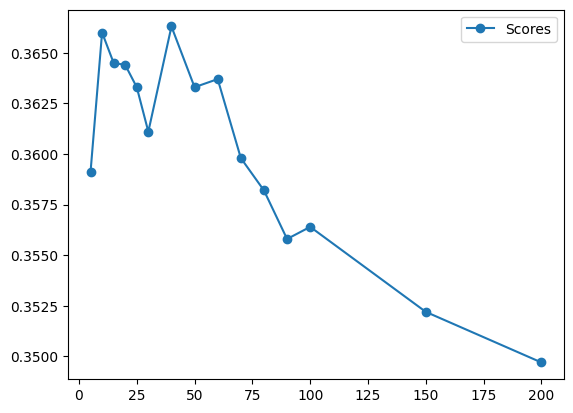

In [26]:
import matplotlib.pyplot as plt

plt.plot( [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200], scores, '-o', label="Scores")
plt.legend()
plt.show()

In [27]:
scores

[0.3591,
 0.366,
 0.3645,
 0.3644,
 0.3633,
 0.3611,
 0.3663,
 0.3633,
 0.3637,
 0.3598,
 0.3582,
 0.3558,
 0.3564,
 0.3522,
 0.3497]